In [7]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [8]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [22]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [10]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
engine

Engine(sqlite:///Resources/hawaii.sqlite)

In [12]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect =True)

In [14]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [15]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [16]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [23]:
inspector=inspect(engine)

In [17]:
stations = engine.execute('Select * From Station')

In [18]:
print(stations.keys())

RMKeyView(['id', 'station', 'name', 'latitude', 'longitude', 'elevation'])


In [82]:
stations.fetchall()

[]

In [24]:
columns= inspector.get_columns('Station')
for column in columns:
    print (column['name'], column['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [25]:
measurements = engine.execute('Select * From Measurement')

In [77]:
print(measurements.keys())

RMKeyView(['id', 'station', 'date', 'prcp', 'tobs'])


In [78]:
measurements.fetchall()

[]

In [79]:
columns = inspector.get_columns('Measurement')
for column in columns:
    print (column['name'], column['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


# Exploratory Precipitation Analysis

Query Date: 2016-08-23


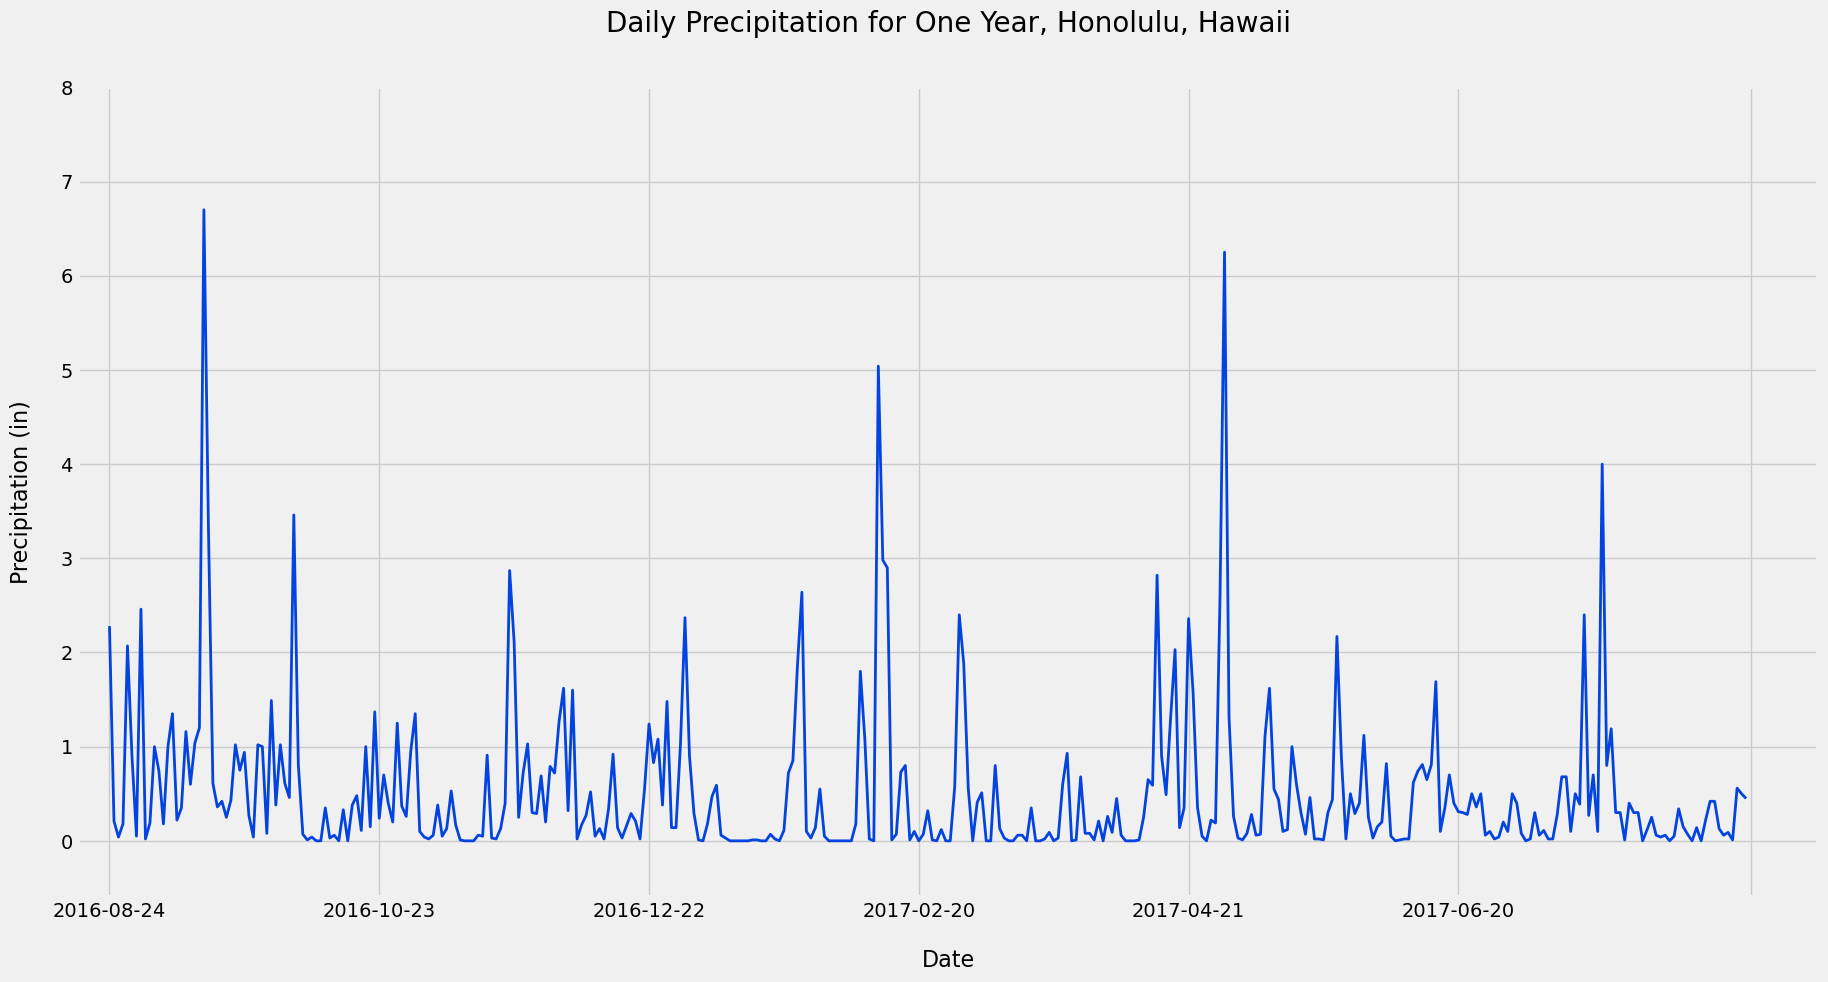

In [51]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
year_to_date = dt.date( 2017, 8, 23)-dt.timedelta(days=365)
print('Query Date:', year_to_date)

# Perform a query to retrieve the data and precipitation scores
precip = session.query(Measurement.date,func.max(Measurement.prcp)).filter(func.strftime('%Y-%m-%d', Measurement.date) 
                                                                           > year_to_date).group_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
precip_df = pd.DataFrame(precip, columns= ['date', 'prcp'])
precip_df.set_index('date', inplace=True)
precip_df.head(10)

# Sort the dataframe by date
precip_df.sort_values('date')

# Use Pandas Plotting with Matplotlib to plot the data
plt.rcParams['figure.figsize']=(20,10)
precip_df.plot(linewidth=2, alpha =1, rot=0,
              xticks=(0,60,120,180,240,300,365),
              color='xkcd:blue')
plt.xlim(-7,380)
plt.ylim(-.6,8)
plt.yticks(size=14)
plt.xticks(fontsize=14)
plt.legend('',frameon=False)
plt.xlabel('Date', fontsize=16, color='black', labelpad=20)
plt.ylabel('Precipitation (in)', fontsize=16, color='black',labelpad=20)
plt.title('Daily Precipitation for One Year, Honolulu, Hawaii', fontsize =20, pad=40)

plt.show()


In [50]:
# Use Pandas to calculate the summary statistics for the precipitation data
precip_stats = session.query(Measurement.date,Measurement.prcp).filter(Measurement.date > year_to_date).all()

precip_stats_df = pd.DataFrame(precip_stats, columns = ['date', 'prcp'])
precip_stats_df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [59]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(Station.station).count()
print(f'The total number of stations is {total_stations}.')

The total number of stations is 9.


In [61]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
active_stations = (session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all())
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [65]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active = [Measurement.station,func.max(Measurement.tobs), func.min(Measurement.tobs), func.avg(Measurement.tobs)]

active_station = (session.query(*most_active).filter(Measurement.station=='USC00519281').all())

active_station
                


[('USC00519281', 85.0, 54.0, 71.66378066378067)]

In [70]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
tobs_data = (session.query(Measurement.date,(Measurement.tobs)).filter(func.strftime(Measurement.date)> year_to_date).filter(Measurement.station =='USC00519281').all())
tobs_data_df = pd.DataFrame(tobs_data)



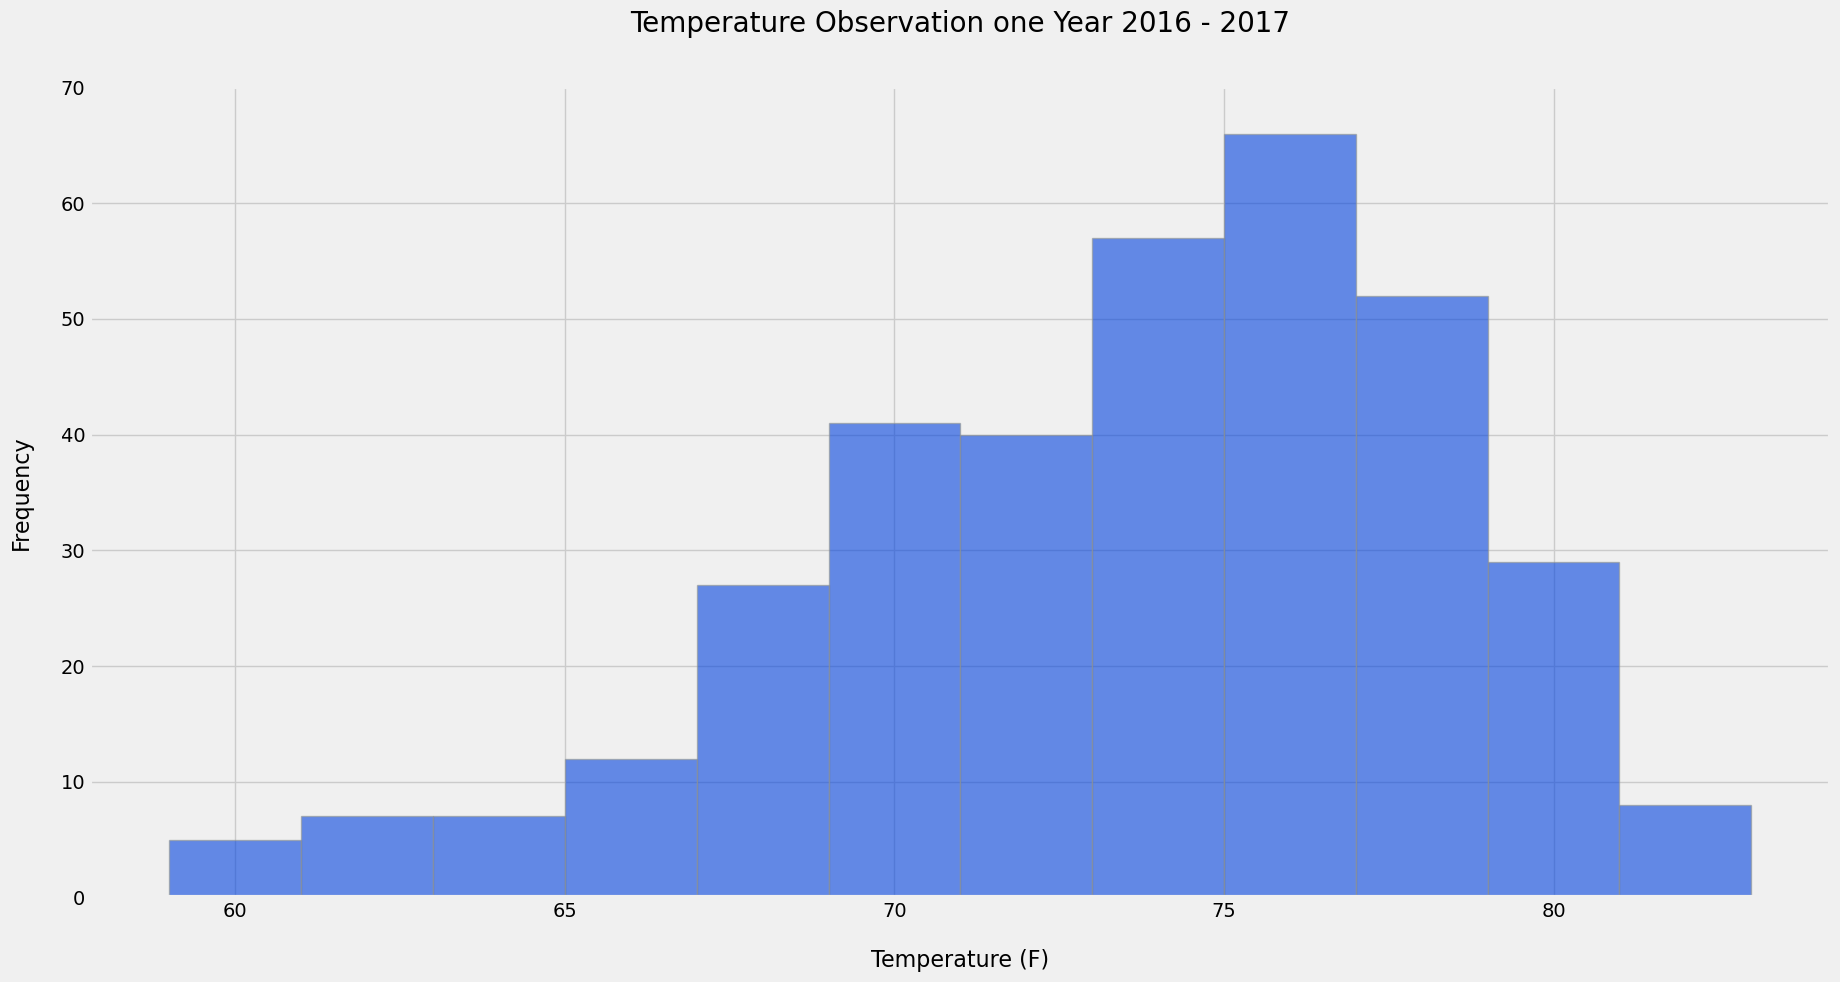

In [73]:
plt.rcParams['figure.figsize']=(20,10)
plt.hist(tobs_data_df['tobs'],bins=12, alpha=.6, edgecolor='xkcd:grey',
         linewidth=1,color='xkcd:blue')
    
    

plt.ylim(0,70)
plt.yticks(size=14)
plt.xticks(fontsize=14)
plt.legend('',frameon=False)
plt.xlabel('Temperature (F)', fontsize=16, color='black', labelpad=20)
plt.ylabel('Frequency', fontsize=16, color='black',labelpad=20)
plt.title('Temperature Observation one Year 2016 - 2017', fontsize =20, pad=40)

plt.show()

# Close Session

In [74]:
# Close Session
session.close()